# MTH3302 - Méthodes probabilistes et statistiques pour I.A.
#### Polytechnique Montréal


### Projet A2024

-----

# Prédiction de la consommation en carburant de voitures récentes

### Contexte

Dans le cadre de ce projet, on nous fournit un jeu de données comprenant différentes caractéristiques de véhicules à essence ainsi que leur consommation d'essence en L/100km.

### Objectif

L'objectif du projet est de prédire, pour un ensemble de données de validation, la consommation d'essence d'un véhicule en se fiant à ses autres caractéristiques.  Pour ce faire, nous explorerons différentes avenues tant au niveau du traitement des données d'entraînement qu'au niveau de la conception d'un modèle. 

### Données

Les données utilisées pour inférer la consommation de carburant sont les suivantes :

- `train.csv` : données d'un ensemble d'entraînement qui comprennent différentes caractéristiques de véhicules et leur consommation d'essence associée 
- `test.csv` : données d'un ensemble de validation qui comprennent tout sauf la consommation d'essence

## 1. Chargement des données

Commençons par importer les librairies nécessaires à l'utilisation de ce calepin.

In [1]:
using CSV, DataFrames, Statistics, Dates, Gadfly, Combinatorics, Plots, StatsBase, StatsPlots, Random, StatsModels, GLM, LinearAlgebra, MultivariateStats, Distributions

Nous pouvons ensuite charger les données de l'ensemble d'entraînement et de l'ensemble de validation.

In [2]:
full_train = CSV.read("../data/raw/train.csv", DataFrame; delim=";")
test =  CSV.read("../data/raw/test.csv", DataFrame; delim=";") # ne contient pas la variable "consommation"

Random.seed!(1234) # pour la reproductibilité

ntrain = round(Int, .8*nrow(full_train)) # 80% des données pour l'entraînement: 80% * nb de lignes

train_id = sample(1:nrow(full_train), ntrain, replace=false, ordered=true) # échantillonnage aléatoire pour l'entraînement
valid_id = setdiff(1:nrow(full_train), train_id) # échantillon de validation ; prend les données qui ne sont pas dans l'échantillon d'entraînement

train = full_train[train_id, :]  
valid = full_train[valid_id, :]

Row,annee,type,nombre_cylindres,cylindree,transmission,boite,consommation
,Int64,String31,Int64,String3,String15,String15,String31
1,2024,voiture_moyenne,8,"4,4",integrale,automatique,"12,3794736842105"
2,2024,voiture_sous_compacte,6,3,propulsion,automatique,"9,80041666666667"
3,2021,voiture_deux_places,6,3,propulsion,automatique,"10,6913636363636"
4,2018,voiture_compacte,4,2,propulsion,manuelle,"9,4084"
5,2015,VUS_standard,8,"6,2",4x4,automatique,"14,700625"
6,2021,VUS_petit,4,2,traction,automatique,"7,58741935483871"
7,2018,voiture_sous_compacte,4,2,integrale,manuelle,"8,71148148148148"
8,2014,VUS_standard,8,"4,8",integrale,automatique,"13,8358823529412"
9,2022,voiture_sous_compacte,8,"4,4",integrale,automatique,"12,3794736842105"


In [3]:
first(valid, 5)

Row,annee,type,nombre_cylindres,cylindree,transmission,boite,consommation
,Int64,String31,Int64,String3,String15,String15,String31
1,2024,voiture_moyenne,8,"4,4",integrale,automatique,"12,3794736842105"
2,2024,voiture_sous_compacte,6,3,propulsion,automatique,"9,80041666666667"
3,2021,voiture_deux_places,6,3,propulsion,automatique,"10,6913636363636"
4,2018,voiture_compacte,4,2,propulsion,manuelle,"9,4084"
5,2015,VUS_standard,8,"6,2",4x4,automatique,"14,700625"


In [4]:
first(test, 5)

Row,annee,type,nombre_cylindres,cylindree,transmission,boite
,Int64,String31,Int64,String3,String15,String15
1,2014,voiture_moyenne,4,"2,5",traction,manuelle
2,2014,voiture_moyenne,4,"2,5",traction,automatique
3,2014,VUS_petit,4,"2,5",traction,automatique
4,2014,VUS_petit,4,2,4x4,automatique
5,2014,voiture_sous_compacte,8,"5,8",propulsion,manuelle


On constate donc que les données ont été bien chargées, et que l'ensemble de test comprend également une colonne de moins que l'ensemble full_train, soit la colonne de consommation d'essence.  De plus, nous avons séparé le jeu de données d'entraînement en deux sous-groupes : 80% pour l'entraînement dans la variable "train", et le 20% restant pour assurer la validation dans la variable "valid".

## 2. Helpers

Pour continuer, nous avons créé quelques fonctions génériques qui seront utiles à plusieurs reprises plus loin dans le calepin.  Afin d'éviter des répétitions inutiles de ces procédés, et pour s'assurer de pouvoir retracer ces fonctions rapidement, elles sont regroupées sous cette rubrique "helpers".

D'abord, nous avons réalisé en affichant les données à la section précédente que deux données numériques, la cylindrée et la consommation, étaient en format String plutôt que d'un type Float. Naturellement, cette incohérence dans le jeu de données nous empêchera de travailler avec celles-ci, et c'est pourquoi nous nous sommes munis d'un outil de conversion en Float.

In [5]:
function safe_parse_float(x)
    try
        return parse(Float64, x)
    catch
        return missing
    end
end

safe_parse_float (generic function with 1 method)

De plus, pour les données non numériques comme le type de véhicule, la transmission et la boîte, nous devons nous munir d'une méthode de conversion pour encoder ces données de façon à ce que le modèle d'apprentissage automatique puissent les traiter adéquatement.  La méthode que nous avons choisie est l'encodage "one-hot", qui consiste à créer une nouvelle colonne pour chaque catégorie et à assigner la valeur 1 à cette colonne si c'est la rangée correspond à cette catégorie, et la valeur 0 dans tous les autres cas.  Nous avons choisi la méthode one-hot afin d'éviter les problèmes que l'autre méthode d'encodage populaire que nous considérions, l'encodage ordinal, peut poser, notamment les biais de magnitude (0 et 1 sont des valeurs neutres qui ne discriminent pas entre les catégories, contrairement aux valeurs ordinales 1, 2, 3, ... qui peuvent influencer les prédictions). 

In [6]:
function one_hot_encode(df, cols, levels_dict)
    for col in cols
        levels_col = levels_dict[col]
        for level in levels_col
            new_col = Symbol(string(col) * "_" * string(level))
            df[!, new_col] = ifelse.(df[!, col] .== level, 1.0, 0.0)
        end
        select!(df, Not(col))
    end
    return df
end

one_hot_encode (generic function with 1 method)

Afin d'accélérer le développement de notre solution, nous nous sommes également munis d'une fonction qui applique un pre-processing de base aux jeux de données pertinents.  Cette méthode commencer par remplacer les virgules par des points dans les colonnes numériques qui sont en String par défaut dans les jeux de données, puis applique la conversion en Float directement et retire les valeurs manquantes à la fin.

In [ ]:
function default_prerocessing(data)

datasets_with_consommation = [data]
datasets_without_consommation = [test]

for df in [data]
    df.cylindree = replace.(df.cylindree, "," => ".")
end

for df in datasets_with_consommation
    df.consommation = replace.(df.consommation, "," => ".")
end

for df in [data]
    df.cylindree = safe_parse_float.(df.cylindree)
end

for df in datasets_with_consommation
    df.consommation = safe_parse_float.(df.consommation)
end

for df in [data]
    dropmissing!(df)
end

end

default_prerocessing (generic function with 1 method)

In [8]:
function remove_outliers_by_iqr(df, group_col, value_col)
    return combine(groupby(df, group_col)) do sdf
        q1 = quantile(sdf[!, value_col], 0.25)
        q3 = quantile(sdf[!, value_col], 0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        filter(row -> lower_bound ≤ row[value_col] ≤ upper_bound, sdf)
    end
end

remove_outliers_by_iqr (generic function with 1 method)

In [9]:
function categorize_vehicle_type(vehicle_type)
    if vehicle_type in ["break_petit", "voiture_minicompacte", "voiture_compacte", "VUS_petit", "voiture_moyenne"]
        return "petits_véhicules"
    elseif vehicle_type in ["voiture_sous_compacte", "break_moyen", "monospace", "camionnette_petit"]
        return "véhicules_moyens"
    else
        return "grands_véhicules"
    end
end

categorize_vehicle_type (generic function with 1 method)

In [10]:
function compute_raj(X, y, ŷ)
    SSe = sum((ŷ .- y).^2)
    SSt = sum((y .- mean(y)).^2)
    n = size(y, 1)
    p = size(X, 2)
    return 1 - (SSe / (n - p - 1)) / (SSt / (n - 1))
end

compute_raj (generic function with 1 method)

In [11]:
function compute_bic(X, model)

    log_likelihood = loglikelihood(model)
    
    n = size(X, 1)  
    k = length(coef(model))  

    bic = log_likelihood - (k/2) * log(n)

    return bic
end

compute_bic (generic function with 1 method)

## 3. Exploration des données

Commençons par nous familiariser avec les données à notre disposition. Dans cette section, nous allons explorer différentes pistes qui pourraient potentiellement avoir un impact positif sur nos prédictions, que ce soit de répérer des données éloignées du reste de l'ensemble, de répérer des tendances, de détecter des instances de multicolinéarité, etc.

La première étape pour traiter les données est de copier les données d'entraînement dans une variable "data" afin d'éviter de corrompre les données originales lors de nos manipulations. On peut ensuite retirer les valeurs manquantes.

In [ ]:
# faire une copie initiale du dataframe
data = deepcopy(train)

# retirer les colonnes ayant des données vides de notre dataframe
data = dropmissing(data)

# procéder au prétraitement par défaut
default_prerocessing(data)

first(data, 5)

### Variables explicatives

Nous allons commencer par analyser chacune des variables explicatives potentielles en détail.

#### Année

La première variable explicative est l'année de fabrication du véhicule. Nous avons commencé par regarder la tendance de la consommation d'essence au fil des ans.

In [ ]:
set_default_plot_size(16cm, 12cm)
Gadfly.plot(
    data,
    x=:annee,
    y=:consommation,
    Geom.boxplot,
    Guide.title("Consommation d'essence en fonction de l'année du véhicule"),
    Guide.xlabel("Année"),
    Guide.ylabel("Consommation (L/100km)"),
    Guide.xticks(ticks=collect(2013:1:2025)),
)

On peut tirer quelques observations de ce diagramme. D'abord, les données de l'ensemble d'entraînement sont réparties sur une période de seulement 10 ans, soit de 2014 à 2024. Ceci fait en sorte que les consommations d'essence correspondantes varieront peu d'une année à l'autre, car les véhicules ne se sont pas améliorés technologiquement de façon assez significative sur une aussi courte période pour que l'année de fabrication ait une incidence notable sur la consommation d'essence. De plus, lorsqu'on observe le diagramme, il est difficile de remarquer une tendance claire dans la variation de la consommation d'essence sur la période de 10 ans. La consommation d'essence semblait être à la hausse en 2022 et 2023, avant de rechuter en 2024. Ces variations nous semblent difficiles à modéliser. Pour toutes ces raisons, il nous semble initialement que l'année de fabrication soit une variable explicative de faible impact sur les prédictions.

Ensuite, nous nous sommes questionnés par rapport à la grosseur des chiffres reliées à l'année dans un modèle. En effet, les autres données numériques étant le nombre de cylindres et la cylindrée, qui ont tous les deux des valeurs nettement inférieures à un chiffre comme 2020, nous nous demandions si cette disparité pouvait avoir un impact sur la qualité de nos prédictions. Nous avons donc opté pour la stratégie de changer la variable explicative de l'année de fabrication pour une variable d'âge, qui serait entre 1 et 10 ans, et qui serait beaucoup plus proche des valeurs des autres variables explicatives. Ci-dessous se trouve notre façon de procéder.

In [ ]:
data.age = 2024 .- data.annee

select!(data, Not(:annee))
first(data, 5)

À partir de ces données, nous avons essayé de remplacer l'année de fabrication par l'âge du véhicule dans notre modèle le plus performant. Nous avons noté une amélioration de ${10}^{-12}$ de notre RMSE. Il va donc sans dire que cette modification de nos variables explicatives était totalement inutile. Nous garderons donc l'année de fabrication pour la suite de nos tests, bien que nous ayons peu d'espoir que cette variable se retrouve dans le modèle final étant donné sa faible corrélation avec la consommation d'essence pour toutes les raisons mentionnées ci-haut.

#### Type de véhicule

Analysons maintenant une seconde variable, soit le type de véhicule. Commençons par vérifier le nombre de types différents dans l'échantillo, ainsi que la quantité d'observations pour chacune des catégories listées. 

In [ ]:

unique_categories = unique(skipmissing(data[:, :type]))
occurences = [sum(skipmissing(data[:, :type]) .== category) for category in unique_categories]
occurences = DataFrame(category = unique_categories, occurences = occurences)
sort!(occurences, :occurences, rev=true)

Comme on peut le constater, il y a des grandes différences au niveau du nombre d'observations pour chaque type de véhicule: certains, comme les VUS petits, sont représentés à de nombreuses reprises (86), tandis que d'autres, comme les camionnettes standards, sont très rares (2). On peut également illustrer ces données sous la forme d'un graphique des occurences selon les différents types de véhicules.

In [ ]:
set_default_plot_size(20cm, 20cm)
Gadfly.plot(
    occurences,
    x=:category,
    y=:occurences,
    Geom.bar,
    Guide.title("Répartition des types de véhicules"),
    Guide.xlabel("Type de véhicule"),
    Guide.ylabel("Occurrences"),
)

Calculons maintenant les moyennes de consommation par type de véhicule, ce qui pourrait nous informer sur la variable d'intérêt : en effet, il nous semble a priori logique qu'un type de véhicule plus gros comme une camionnette consomme beaucoup plus qu'un véhicule léger comme une voiture mini-compacte. On affiche aussi ces valeurs dans un graphique.

In [ ]:
mean_values = combine(groupby(data, :type), :consommation => mean => :mean_consommation)

In [ ]:
@df mean_values bar(:type, :mean_consommation, xlabel="Type de véhicule", ylabel="Consommation Moyenne", title="Consommation moyenne par type de véhicule", legend=false, rotation=45)

À partir du graphique ci-haut représentant la consommation d'essence moyenne en fonction du type de véhicule, il est possbile de remarquer des similarités par rapport à la consommation de certains types de véhicules. Afin de contrer le fait que certaines catégories ont très peu d'observations, ce qui rend l'interprétation des tendances générales plus difficile en raison du bruit, nous avons décidé de regrouper certaines catégories similaires. Cela permet aussi de contribuer à réduire la multicolinéarité en réduisant le nombre de variables explicatives similaires. La méthode que nous avons employée est la suivante :

In [ ]:
function categorize_vehicle_type(vehicle_type)
    if vehicle_type in ["break_petit", "voiture_minicompacte", "voiture_compacte", "VUS_petit", "voiture_moyenne"]
        return "petits_véhicules"
    elseif vehicle_type in ["voiture_sous_compacte", "monospace", "camionnette_petit",]
        return "véhicules_moyens"
    else
        return "grands_véhicules"
    end
end

Nous avons donc regroupé les caétgories "break_petit", "voiture_minicompacte", "voiture_compacte", "VUS_petit" et "voiture_moyenne" dans la nouvelle catégorie "petits_véhicules", les "voiture_sous_compacte", "monospace" et "camionnette_petit" dans la nouvelle catégorie "véhicules_moyens", et tous les autres dans la catégorie "grands_véhicules". Analysons maintenant les performances de ces trois nouvelles catégories dans un modèle de régression linéaire, en les comparant avec les performances des types de véhicules avant le regroupement.

In [ ]:
dataWithCategorie = deepcopy(data)

dataWithCategorie[:, :categorie_vehicule] = [categorize_vehicle_type(t) for t in dataWithCategorie[:, :type]]
categorical_cols = [:categorie_vehicule,]

levels_dict = Dict()
for col in categorical_cols
    levels_dict[col] = unique(dataWithCategorie[!, col])
end

data_type_encoded = one_hot_encode(dataWithCategorie, categorical_cols, levels_dict)
model = lm(@formula(consommation ~ categorie_vehicule_petits_véhicules + categorie_vehicule_grands_véhicules + categorie_vehicule_véhicules_moyens), dataWithCategorie)

dataWithCategorie.predicted = predict(model)

println("R²: ", r2(model))
rmse = sqrt(mean((dataWithCategorie.consommation .- dataWithCategorie.predicted).^2))

println("RMSE: ", rmse)

In [ ]:
dataWithType = deepcopy(data)

categorical_cols = [:type,]

levels_dict = Dict()
for col in categorical_cols
    levels_dict[col] = unique(dataWithType[!, col])
end

data_type_encoded = one_hot_encode(dataWithType, categorical_cols, levels_dict)

model = lm(@formula(consommation ~ type_voiture_moyenne + type_VUS_petit + type_voiture_compacte + type_voiture_deux_places + type_voiture_minicompacte + type_VUS_standard + type_monospace + 
                    type_camionnette_petit + type_voiture_sous_compacte + type_break_petit + type_voiture_grande + type_camionnette_standard), dataWithType)

dataWithType.predicted = predict(model)

println("R²: ", r2(model))
rmse = sqrt(mean((dataWithType.consommation .- dataWithType.predicted).^2))

println("RMSE: ", rmse)

À la lumière des valeurs obtenues, on conclut que lorque seules ces nouvelles catégories sont incluses dans le modèle, elles performent moins bien que lorsque seuls les types originals sont inclus dans le modèle, autant au niveau du ${R^2}$ que du RMSE. Cette tentative de réduire la dimensionalité du vecteur de paramètres est donc un échec dans le cas où le type est le seul paramètre étudié.  Nous verrons plus loin que lorsque le regroupement par catégories est associé à d'autres variables explicatives, cette méthode bonifie le RMSE.

Regardons maintenant la relation entre le type de véhicule et la cylindrée afin de vérifier si certains types de véhicules ont une consommation plus élevée en raison d'une cylindrée importante.

In [ ]:
set_default_plot_size(16cm, 12cm)
Gadfly.plot(
    data,
    x=:cylindree,
    y=:consommation,
    color=:type,
    Geom.point,
    Guide.title("Consommation d'essence en fonction de la cylindrée, catégorisée par type de véhicule"),
    Guide.xlabel("Cylindrée"),
    Guide.ylabel("Consommation (L/100km)"),
    Guide.colorkey("Type de véhicule"),
)

##### Cylindrée

Généralement, la cylindée d'un véhicule est hautement corrélée à la consommation d'essence de celui-ci. Toutefois, la cylindrée est une variable continue avec énormément de valeurs uniques, ce qui peut compliqué la modélisation de la consommation d'essence. De plus, la distibuion des échantillions est asymétrique. Nous avons donc décidé d'étudier la nécessité de transformer cette variable en une variable catégorielle. Pour ce faire, nous avons d'abord regardé la distribution des cylindrées dans notre ensemble de données. 

L'idée est de créer des catégories de cylindrées, par exemple, les véhicules avec une cylindrée de moins de 2L, entre 2L et 3L, et plus de 3L. Nous avons donc créé un histogramme de la distribution des cylindrées pour nous aider à déterminer les catégories à utiliser.

In [ ]:
unique_cylindree = unique(skipmissing(data[:, :cylindree]))
occurences_cylindree = [sum(skipmissing(data[:, :cylindree]) .== cylindree) for cylindree in unique_cylindree]
occurences_cylindree = DataFrame(cylindree = unique_cylindree, occurences = occurences_cylindree)

set_default_plot_size(20cm, 20cm)
Gadfly.plot(
    occurences_cylindree,
    x=:cylindree,
    y=:occurences,
    Geom.bar,
    Guide.title("Répartition des cylindrées"),
    Guide.xlabel("Cylindrée"),
    Guide.ylabel("Occurrences"),
)

Comme mentionné, la distribution des cylindrées est très asymétrique, avec une majorité de véhicules ayant une cylindrée de moins de 3L. De plus nous pouvons appercevoir des valeurs extrêmes qui devraient être traitées pour ne pas introduire de bruit dans notre modèle. Dans notre modèle final, nous n'avons toutefois pas pris compte de la correction de cette asymmétrie. Nous allons donc plutôt étudier la relation entre la cylindrée et la consommation d'essence.

In [ ]:
# Ajuster un modèle de régression linéaire
model = lm(@formula(consommation ~ cylindree), data)

# Prédire les valeurs de consommation pour tracer la ligne
data.predicted = predict(model)

# Tracer avec Gadfly
p = Gadfly.plot(
    data,
    x=:cylindree,
    y=:consommation,
    Geom.point,
    layer(data, x=:cylindree, y=:predicted, Geom.line, Theme(default_color="red")),
    Guide.title("Consommation d'essence en fonction de la cylindrée"),
    Guide.xlabel("Cylindrée"),
    Guide.ylabel("Consommation (L/100km)"),
)

display(p)

println("R²: ", r2(model))
rmse = sqrt(mean((data.consommation .- data.predicted).^2))

println("RMSE: ", rmse)

# calcul des résidus
res = data.consommation .- data.predicted

p1 = Gadfly.plot(
    data,
    x=:cylindree,
    y=res,
    Geom.point,
    Guide.title("Résidus de la régression linéaire"),
    Guide.xlabel("Cylindrée"),
    Guide.ylabel("Résidus"),
)
display(p1)

Comme nous pouvons le voir, il semble y avoir une relation croissante entre la cylindrée et la consommation de carburant. C'est ce qui était attendu, mais nous remarquons que la relation n'est pas parfaitemnt linéaire. Si nous voulons respecter le principe de linéarité, nous devons transformer la variable explicative pour respecter l'hypothèses 1. Pour ce faire, nous allons appliquer le logarithme des cylindrées pour voir si cela améliore la linéarité de la relation.

In [ ]:
data.cylindree = log.(data.cylindree)

In [ ]:
# Ajuster un modèle de régression linéaire
model = lm(@formula(consommation ~ cylindree), data)

# Prédire les valeurs de consommation pour tracer la ligne
data.predicted = predict(model)

# Tracer avec Gadfly
Gadfly.plot(
    data,
    x=:cylindree,
    y=:consommation,
    Geom.point,
    layer(data, x=:cylindree, y=:predicted, Geom.line, Theme(default_color="red")),
    Guide.title("Consommation d'essence en fonction de la cylindrée"),
    Guide.xlabel("Cylindrée"),
    Guide.ylabel("Consommation (L/100km)"),
    Guide.colorkey("Catégorie de cylindrée"),
)

In [ ]:
# appliquer le logaritme sur la cylindree
data.cylindree = log.(data.cylindree)

println("R²: ", r2(model))
rmse = sqrt(mean((data.consommation .- data.predicted).^2))
println("RMSE: ", rmse)

# calcul des résidus
res = data.consommation .- data.predicted

p1 = Gadfly.plot(
    data,
    x=:cylindree,
    y=res,
    Geom.point,
    Guide.title("Résidus de la régression linéaire"),
    Guide.xlabel("Cylindrée"),
    Guide.ylabel("Résidus"),
)
display(p1)


Comme nous pouvons le voir, la relation entre la consommation d'essence et la cylindrée semble être plus linéaire après avoir appliqué le logarithme. Nous allons donc utiliser cette transformation pour la suite de notre analyse.

##### Nombre de cylindres

Examinons maintenant une autre variable numérique : le nombre de cylindres du moteur. Commençons par déterminer combien de variables uniques existent pour cette variable explicative potentielle.

In [ ]:
unique_nb_cylindres = unique(data[:, :nombre_cylindres])
occurences = [sum(data[:, :nombre_cylindres] .== nb_cylindres) for nb_cylindres in unique_nb_cylindres]
occurences = DataFrame(nb_cylindres = unique_nb_cylindres, occurences = occurences)
sort!(occurences, :occurences, rev=true)

Comme on peut le constater, la grande majorité des véhicules étudiés ont 4 cylindres (148), 6 cylindres (87), 8 cylindres (51) ou 3 cylindres (24). Seuls quelques véhicules ont un plus grand nombre de cylindres (3 véhicules de 12 cylindres et 3 véhicules de 10 cylindres), et une seul véhicule a 5 cylindres. Pour ces valeurs pour lesquelles nous disposons de moins de données d'entraînement, il est donc possible de penser que le modèle sera moins efficace dans ses prédictions. Ce sera une hypothèse que nous considérerons plus loin dans l'entraînement de nos modèles. On pourrait décider d'omettre ces données en appliquant la modification suivante au dataframe (conserver la valeur seulement si elle est associée à plus de 5 occurences):

In [ ]:
occurences = occurences[occurences.occurences .> 5, :]

On peut aussi visualiser ces données sous forme de diagramme pour obtenir une meilleure compréhension de celles-ci :

In [ ]:
set_default_plot_size(16cm, 12cm)
Gadfly.plot(
    data,
    x=:nombre_cylindres,
    y=:consommation,
    Geom.point,
    Guide.title("Consommation d'essence en fonction du nombre de cylindres du véhicule"),
    Guide.xlabel("Nombre de cylindres (log)"),
    Guide.ylabel("Consommation (L/100km)"),
)

On reconnait ici une forme logarithmique. Essayons d'appliquer un log aux valeurs du nombre de cylindre pour obtenir une distribution linéaire.

In [ ]:
data.nombre_cylindres = log.(data.nombre_cylindres)

set_default_plot_size(16cm, 12cm)
Gadfly.plot(
    data,
    x=:nombre_cylindres,
    y=:consommation,
    Geom.point,
    Guide.title("Consommation d'essence en fonction du nombre de cylindres du véhicule (log)"),
    Guide.xlabel("Nombre de cylindres (log)"),
    Guide.ylabel("Consommation (L/100km)"),
)

Si on utilise la valeur ajustée avec le logarithme du nombre de cylindres, on obtient les prédictions préliminaires suivantes avec les résidus :

In [ ]:
model = lm(@formula(consommation ~ nombre_cylindres), data)

data.predicted = predict(model)

p = Gadfly.plot(
    data,
    x=:nombre_cylindres,
    y=:consommation,
    Geom.point,
    layer(data, x=:nombre_cylindres, y=:predicted, Geom.line, Theme(default_color="red")),
    Guide.title("Consommation d'essence en fonction de la cylindrée"),
    Guide.xlabel("Cylindrée"),
    Guide.ylabel("Consommation (L/100km)"),
)

display(p)


p1 = Gadfly.plot(
    data,
    x=:nombre_cylindres,
    y=res,
    Geom.point,
    Guide.title("Résidus de la régression linéaire"),
    Guide.xlabel("Cylindrée"),
    Guide.ylabel("Résidus"),
)

display(p1)


On voit donc que plus le nombre de cylindres est grand, plus la consommation d'essence moyenne a tendance à augmenter aussi. Compte tenu de cette observation et du fort coefficient de corrélation entre la consommation et le nombre de cylindres, il semble que ce dernier constitue une variable explicative de fort intérêt pour notre modèle prédictif.

Comme la cylindrée du véhicule présentait des caractéristiques similaires à celles du nombre de cylindres, nous avons étudié la relations entre ces deux variables explicatives. Curieux de savoir si l'intéraction des deux variables apportait une information supplémentaire, nous souhaitions examiner si la combinaison des deux était pertinente. Nous avons donc créé une nouvelle variable qui représentait la capacité moteur du véhicule, soit le produit de la cylindrée et du nombre de cylindres. Toutefois, nous avons constaté que cette nouvelle variable n'apportait pas d'information supplémentaire par rapport à la cylindrée et au nombre de cylindres, et nous avons donc décidé de ne pas l'inclure dans notre modèle final.

##### Transmission 

En ce qui concerne le type de transmission, nous avons commencé par observer la distribution des catégories:

In [ ]:
for df in [data]
    println("Nombre d'observations par type de transmission :")
    println(combine(groupby(df, :transmission), nrow))
end

Comme nous pouvons le voir, les types de transmission sont représentées inégalement dans l'ensemble de données. Les transmissions integrale et à traction sont largement représentées, tandis que les transmissions à propulsion et 4x4 sont sous-représentées. Cela nous mène à questionner l'effet de ce manque sur les prédictions. Effectivement, si les types de transmission sont corrélés à la consommation d'essence, le fait que certaines catégories soient sous-représentées pourrait biaiser nos prédictions.

In [ ]:
# histogramme de la consommation moyenne en fonction du type de transmission
set_default_plot_size(20cm, 20cm)

mean_consommation = combine(groupby(data, :transmission), :consommation => mean => :mean_consommation)
# moyenne par type de transmission
println(mean_consommation)

Gadfly.plot(
    mean_consommation,
    x=:transmission,
    y=:mean_consommation,
    Geom.bar,
    Guide.xlabel("Transmission"),
    Guide.ylabel("Consommation moyenne (L/100km)"),
    Guide.title("Consommation moyenne en fonction du type de transmission")
)

Comme, les prédictions risquent d'être biaisées vers des valeurs associées aux classes majoritaires ("integrale" ou "traction"), nous pourrions poser l'hypothèse que le modèle risque de sous-estimer non seulement la consommation des véhicules avec une transmission 4x4 et propulsion, mais aussi les prédictions globales en raison de la forte représentation de la transmission traction. (Voir histogramme de la consommation par type de transmission). Pour pallier à ce problème, nous pourrions envisager de pondérer ou de regrouper les classes de transmission pour équilibrer les données. Par exemple, nous pourrions ajouter un poids élevé à la classe "4x4" et un poids plus faible à la classe "Traction" pour compenser leur représentation respective. Nous pourrions également regrouper les classes "Intégrale" et "Propulsion" en une seule catégorie pour augmenter leur représentation dans l'ensemble de données, si leur distinction n'apporte pas de valeur ajoutée au modèle.

##### Approche A: Ajustement de poids

In [ ]:
full_train = CSV.read("../data/raw/train.csv", DataFrame; delim=";")
test =  CSV.read("../data/raw/test.csv", DataFrame; delim=";") # ne contient pas la variable consommation

Random.seed!(1234) # pour la reproductibilit

ntrain = round(Int, .8*nrow(full_train)) # 80% des données pour l'entrainement: 80% * nb de lignes

train_id = sample(1:nrow(full_train), ntrain, replace=false, ordered=true) # échantillonnage aléatoire pour l'entrainement
valid_id = setdiff(1:nrow(full_train), train_id) # échantillon de validation. prend celles qui ne sont pas dans l'échantillon d'entrainement

train = full_train[train_id, :]  
valid = full_train[valid_id, :]

In [ ]:
# Jeux de données avec 'consommation'
datasets_with_consommation = [train, valid]

# Jeux de données sans 'consommation'
datasets_without_consommation = [test]

# Remplacer les virgules par des points dans 'cylindree' pour pouvoir convertir en float ensuite
for df in [train, valid, test]
    df.cylindree = replace.(df.cylindree, "," => ".")
end

# Remplacer les virgules par des points dans 'consommation' pour pouvoir convertir en float ensuite
for df in datasets_with_consommation
    df.consommation = replace.(df.consommation, "," => ".")
end

# Convertir 'cylindree' en float dans tous les datasets
for df in [train, valid, test]
    df.cylindree = safe_parse_float.(df.cylindree)
end

# Convertir 'consommation' en float dans les datasets avec 'consommation'
for df in datasets_with_consommation
    df.consommation = safe_parse_float.(df.consommation)
end

# Retirer les valeurs manquantes dans tous les datasets
for df in [train, valid, test]
    dropmissing!(df)
end

In [ ]:
counts = combine(groupby(train, :transmission), nrow => :nrow)

# Étape 2: calculer le nombre total d'échantillons et le nombre de classes
total_samples = sum(counts.nrow)
num_classes = nrow(counts)

# Étape 3: Calculer les poids pour chaque classe
counts.Weight = total_samples ./ (num_classes .* counts.nrow)

# Étape 4: Joindre les poids à l'ensemble de données d'entraînement
train = leftjoin(train, counts[:, [:transmission, :Weight]], on=:transmission)

In [ ]:
# Définir les colonnes catégorielles
categorical_cols = [:transmission,:type]

# Créer un dictionnaire pour stocker les niveaux de chaque colonne catégorielle
levels_dict = Dict()
for col in categorical_cols
    levels_dict[col] = unique(train[!, col])
end

train = one_hot_encode(train, categorical_cols, levels_dict)
valid = one_hot_encode(valid, categorical_cols, levels_dict)

In [ ]:
describe(train)
dropmissing!(train)

In [ ]:
# Ajuster le modèle avec les poids
@time modelA = fit(LinearModel, @formula(consommation ~ transmission_propulsion + transmission_traction + transmission_integrale + transmission_4x4), train, wts = train.Weight)

In [ ]:
# Prédiction avec l'ensemble de validation
valid_prediction = GLM.predict(modelA, valid)
train_prediction = GLM.predict(modelA, train)

# Trouver la moyenne de prédiction
mean_prediction = mean(valid_prediction)
mean_prediction_train = mean(train_prediction)

# Remplacer les missing par la moyenne
valid_prediction = coalesce.(valid_prediction, mean_prediction)
train_prediction = coalesce.(train_prediction, mean_prediction_train)

# Calculer le RMSE
rmse_valid = sqrt(mean((valid_prediction - valid.consommation).^2))
rmse_train = sqrt(mean((train_prediction - train.consommation).^2))

println("RMSE: ", rmse_valid)
println("RMSE train: ", rmse_train)

Pour l'approche A, le rmse nous donne 1.081 ce qui signifie que les prédicitons ne sont pas affectées positivement à l'ajout de poids selon la transmissions. Nous avons donc décidé de ne pas utiliser cette approche. 

##### Approche B: Combinaison de catégories similaires 

Nous devons tester la significativité statistique de la différence entre les catégories de transmission. Pour ce faire, nous avons effectué un test de student pour comparer les moyennes de consommation d'essence entre les différentes catégories de transmission.

In [ ]:
full_train = CSV.read("../data/raw/train.csv", DataFrame; delim=";")
test =  CSV.read("../data/raw/test.csv", DataFrame; delim=";") # ne contient pas la variable consommation

Random.seed!(1234) # pour la reproductibilité

ntrain = round(Int, .8*nrow(full_train)) # 80% des données pour l'entrainement: 80% * nb de lignes

train_id = sample(1:nrow(full_train), ntrain, replace=false, ordered=true) # échantillonnage aléatoire pour l'entrainement
valid_id = setdiff(1:nrow(full_train), train_id) # échantillon de validation. prend celles qui ne sont pas dans l'échantillon d'entrainement

train = full_train[train_id, :]  
valid = full_train[valid_id, :]

In [ ]:
train_data = deepcopy(train)
valid_data = deepcopy(valid)

# Jeux de données avec 'consommation'
datasets_with_consommation = [train_data, valid_data]

# Jeux de données sans 'consommation'
datasets_without_consommation = [test]

# Appliquer les remplacements à 'cylindree' uniquement dans les jeux de données qui le contiennent
for df in [train_data, valid_data, test]
    df.cylindree = replace.(df.cylindree, "," => ".")
end

# Appliquer les remplacements à 'consommation' uniquement dans les jeux de données qui le contiennent
for df in datasets_with_consommation
    df.consommation = replace.(df.consommation, "," => ".")
end

# Convertir 'cylindree' en float dans tous les jeux de données
for df in [train_data, valid_data, test]
    df.cylindree = safe_parse_float.(df.cylindree)
end

# Convertir 'consommation' en float dans les jeux de données ayant la colonne 'consommation'
for df in datasets_with_consommation
    df.consommation = safe_parse_float.(df.consommation)
end

# Retirer les valeurs manquantes dans tous les jeux de données
for df in [train_data, valid_data, test]
    dropmissing!(df)
end

In [ ]:
# Fonction pour calculer la moyenne

function t_test_equal_variances(group1, group2)
    # Tailles des échantillons
    n1 = length(group1)
    n2 = length(group2)

    # Moyennes des deux groupes
    μ1 = mean(group1)
    μ2 = mean(group2)

    # Variances des deux groupes
    s1² = var(group1)
    s2² = var(group2)

    # Variance combinée pondérée
    sp² = ((n1 - 1) * s1² + (n2 - 1) * s2²) / (n1 + n2 - 2)

    # Statistique t
    t_stat = (μ1 - μ2) / sqrt(sp² * (1 / n1 + 1 / n2))

    # Degrés de liberté
    df = n1 + n2 - 2
    
    return t_stat, df
end

In [ ]:

# Exemple d'utilisation
group_integrale = train_data[train_data.transmission .== "integrale", :consommation]
group_4x4 = train_data[train_data.transmission .== "4x4", :consommation]

# Calcul du test t
t_stat, df = t_test_equal_variances(group_integrale, group_4x4)

absolut_t_stat = abs(t_stat)

pvalue = 2 * (1 - cdf(TDist(df), absolut_t_stat))

println("Statistique t : $absolut_t_stat")
println("p-valeur : $pvalue")
println("Degrés de liberté : $df")

Comme le test de student nous donne une p-value > 0.05, nous ne pouvons pas rejeter l'hypothèse nulle selon laquelle les moyennes de consommation d'essence entre les différentes catégories de transmission sont égales. Cela signifie que les différences de consommation d'essence entre les catégories de transmission ne sont pas statistiquement significatives. Par conséquent, nous pouvons regrouper les catégories de transmission similaires pour augmenter leur représentation dans l'ensemble de données sans affecter la qualité des prédictions.

In [ ]:
# Créer une nouvelle colonne pour les catégories de transmission
# si la transmission est 4x4, la remplacer par "integrale"
train_data.transmission = ifelse.(train_data.transmission .== "4x4", "integrale", train_data.transmission)
valid_data.transmission = ifelse.(valid_data.transmission .== "4x4", "integrale", valid_data.transmission)

In [ ]:
# encoder la variable boite
for df in [train_data, valid_data, test]
    df.boite = ifelse.(df.boite .== "automatique", 1.0, 0.0)
end

# définir les colonnes catégorielles
categorical_cols = [:type, :transmission]

# créer un dictionnaire pour stocker les niveaux de chaque colonne catégorielle
levels_dict = Dict()
for col in categorical_cols
    levels_dict[col] = unique(train_data[!, col])
end

train_data = one_hot_encode(train_data, categorical_cols, levels_dict)
valid_data = one_hot_encode(valid_data, categorical_cols, levels_dict)
test = one_hot_encode(test, categorical_cols, levels_dict)

println(names(train_data))

In [ ]:
@time modelB = lm(@formula(consommation ~ 
    transmission_integrale + transmission_traction + transmission_propulsion), train_data)

In [ ]:
# Prédiction avec l'ensemble de validation
valid_prediction = GLM.predict(modelB, valid_data)

# Trouver la moyenne de prédiction
mean_prediction = mean(valid_prediction)

# Remplacer les missing par la moyenne
valid_prediction = coalesce.(valid_prediction, mean_prediction)

# Calculer le RMSE
rmse_valid = sqrt(mean((valid_prediction - valid_data.consommation).^2))

println("RMSE: ", rmse_valid)

##### Boîte

Terminons notre analyse en regardant la dernière variable explicative potentielle avec laquelle nous pouvons travailler, soit la boîte du moteur.  Cette variable peut prendre deux valeurs seulement : automatique ou manuelle.  Commençons par comptabiliser le nombre d'occurences de chaque type au sein de notre ensemble d'entraînement.

In [ ]:
counts = combine(groupby(data, :boite), nrow => :count)

On constate donc qu'il y a beaucoup plus d'observations dans la catégorie des véhicules automatiques (268) que pour les véhicules manuels (49). Regardons maintenant la consommation d'essence associée à chacun des types de boîte.

In [ ]:
set_default_plot_size(16cm, 12cm)
Gadfly.plot(
    data,
    x=:boite,
    y=:consommation,
    Geom.boxplot,
    Guide.xlabel("Boîte"),
    Guide.ylabel("Consommation moyenne (L/100km)"),
    Guide.title("Consommation moyenne en fonction du type de boîte")
)

On constate ici que les deux boîtes se comportent de manière similaire au niveau de la consommation moyenne, avec un écart interquartile un peu plus important pour les véhicules automatiques que pour les véhicules manuels. La variance de la distribution de véhicules automatiques est donc plus grande. On constate aussi la présence d'une donnée abherrante dans la distribution de données du côté manuel, qui pourrait gagner à être retirée lors de l'entraînement du modèle.  Puisque la boîte en soi ne nous informe que très peu sur la consommation d'essence d'un véhciule, on s'intéresse maintenant à la relation entre cette variable et d'autres éléments du jeu de données, notamment le type de véhicule.

In [ ]:
Gadfly.plot(data,
    x = :type,
    y = :consommation,
    color = :boite,
    Geom.point,
    Scale.x_discrete(labels=identity),
    Theme(bar_spacing=0.7)
)

Ce qu'on constate en observant ce graphique, c'est que pour certains types de véhicules, il est impossible que la boîte soit manuelle dans notre jeu de données d'entraînement. Cela fait en sorte qu'il existe possiblement une lacune dans la collecte de données qui ne sont pas assez représentatives, ou alors qu'il s'agit d'un phénomène qu'on pourrait constater en industrie.  Dans tous les cas, cette disparité entre les types de véhicule au niveau de la boîte peut emmener le modèle à faire des prédictions moins fiables pour le types de véhicules n'ayant pas des données à la fois maunelles et automatiques comme les VUS ou les camionnettes. De plus, on ne semble pas détecter que pour un ou des types de véhicules en particulier, le type de boîte ait un gros impact sur la consommation d'essence, pusique les points jaunes se retrouvent souvent au milieu des points bleus.

Une dernière observation que nous pouvons faire est de tracer le graphique de la consommation d'essence en fonction de la cylindrée, une variable explicative que nous avons déjà prouvé comme étant pertinente, mais cette fois-ci selon le type de boîte (une ligne pour les boîtes automatiques et une autre pour les boîtes manuelles). Encore une fois, on constate qu'il y a peu d'incidence sur la consommation d'essence entre les deux modèles.

In [ ]:
aggregated_data = combine(groupby(data, [:cylindree, :boite]), 
    :consommation => mean => :avg_consumption)

Gadfly.plot(aggregated_data,
    x = :cylindree,
    y = :avg_consumption,
    color = :boite,
    Geom.line,
    Guide.xlabel("Cylindrée"),
    Guide.ylabel("Consommation moyenne (L/100km)"),
    Guide.title("Consommation moyenne en fonction de la cylindrée et du type de boîte"),
    Theme(default_color="blue")
)

#### Corrélation entre les variables

Maintenant que nous avons une meilleure idée de l'impact de chaque variable explicative sur la consommation d'essence, il serait intéressant de porter notre attention sur la corrélation entre ces variables. En effet, si deux variables explicatives sont fortement corrélées, cela pourrait poser problème pour la modélisation de la consommation d'essence. En effet, cela pourrait introduire du bruit dans le modèle et nous devrions retirer une des deux variables pour éviter ce problème. Nous allons donc calculer la matrice de corrélation entre les variables explicatives pour voir si ce problème se pose.


In [ ]:
numeric_cols = [:age, :nombre_cylindres, :cylindree, :consommation]

M = cor(Matrix(data[:, numeric_cols]))

# Afficher la matrice de corrélation
println("Matrice de corrélation :")
println(M)

# PLOT
(n,m) = size(M)
heatmap(M, fc=cgrad([:white,:dodgerblue4]), xticks=(1:m,numeric_cols), xrot=90, yticks=(1:m,numeric_cols), yflip=true)
annotate!([(j, i, text(round(M[i,j],digits=3), 8,"Computer Modern",:black)) for i in 1:n for j in 1:m])

Maintenant que nous avons une meilleure idée de l'impact de chaque variable explicative sur la consommation d'essence, il serait intéressant de porter notre attention sur la corrélation entre ces variables. En effet, si deux variables explicatives sont fortement corrélées, cela pourrait poser problème pour la modélisation de la consommation d'essence. En effet, cela pourrait introduire du bruit dans le modèle et nous devrions retirer une des deux variables pour éviter ce problème. Nous allons donc calculer la matrice de corrélation entre les variables explicatives pour voir si ce problème se pose.

## 4. Régression linéaire

Maintenant que nous en avons appris davantage sur les différentes relations entre les variables, il est temps de quantifier la force qu'elles auront sur la variable d'intérêt par une régression linéaire. Pour commencer, nous partitionnons nos données en un ensemble d'entrainement et un ensemble de validation. Pour ce faire, nous utilisons la stratégie du ratio 80/20 et nous intégrerons une validation croisée èa k blocs pour évaluer la performance de notre modèle.

In [85]:
full_train = CSV.read("../data/raw/train.csv", DataFrame; delim=";")
test =  CSV.read("../data/raw/test.csv", DataFrame; delim=";")

Random.seed!(1234) #pour la reproductibilité

ntrain = round(Int, .8*nrow(full_train)) #80% des données pour l'entrainement 

train_id = sample(1:nrow(full_train), ntrain, replace=false, ordered=true) #Échantillonnage aléatoire pour l'entrainement
valid_id = setdiff(1:nrow(full_train), train_id) #Échantillon de validation. On prend les données qui ne sont pas dans l'échantillon d'entrainement

train = full_train[train_id, :]  
valid = full_train[valid_id, :]

first(train, 5)


Row,annee,type,nombre_cylindres,cylindree,transmission,boite,consommation
,Int64,String31,Int64,String3,String15,String15,String31
1,2023,voiture_moyenne,8,"4,4",integrale,automatique,"13,8358823529412"
2,2020,VUS_petit,4,2,integrale,automatique,"9,80041666666667"
3,2021,voiture_compacte,6,"3,3",propulsion,automatique,"11,7605"
4,2023,voiture_deux_places,8,5,integrale,automatique,"13,0672222222222"
5,2022,voiture_moyenne,8,"4,4",integrale,automatique,"13,8358823529412"


Au début du concours, nous ne connaissions pas trop les différentes capacités de la librairie CSV et nous ne savions pas que de simplement ajouter un decimal=',' permettait d'accomplir ce que nous accomplissons dans la prochaine cellule. Nous avons donc décidé de simplement remplacer les virgules par des points dans les colonnes numériques qui sont en String par défaut dans les jeux de données, puis appliquer la conversion en Float directement et retirer les valeurs manquantes à la fin.

In [86]:
datasets_with_consommation = [train, valid]

datasets_without_consommation = [test]

for df in [train, valid, test]
    df.cylindree = replace.(df.cylindree, "," => ".")
end

for df in datasets_with_consommation
    df.consommation = replace.(df.consommation, "," => ".")
end

for df in [train, valid, test]
    df.cylindree = safe_parse_float.(df.cylindree)
end

for df in datasets_with_consommation
    df.consommation = safe_parse_float.(df.consommation)
end

for df in [train, valid, test]
    dropmissing!(df)
end

C'est plutôt ici que le pre-processing est appliqué aux jeux de données pertinents. Effectivement, cette cellule combine les différentes conclusions tirées dans la section d'exploration de données pour exploiter les différentes variables explicatives de manière optimale. Par exemple, comme mentionné dans la section traitant la variable "cylindrée" la première étape consiste à traiter les données abbérantes selon la consommation sous le critère des quantiles. Avec cette stratégie, nous retirons environ 22 observations du training set et 7 du validation set pour une proportion de 6.9% et 9.7% respectivement. Bien que notre expérience est limitée, nous pensons que ces retraits ne sont pas abusifs et l'augmentation de pouvoir prédictif en vaut la peine. Nous avons donc décidé de conserver cette stratégie pour la suite de notre analyse. Le reste consiste à la transformation logarithmique des variables explicatives cylindrée et nombre de cylindres, l'aggrégation des différentes types de transmission et le regroupement des types de véhicules en 3 grandes catégorie selon leur consommation de carburant.

In [87]:
println("Train set: ", size(train))
println("Valid set: ", size(valid))

train = remove_outliers_by_iqr(train, :cylindree, :consommation)
valid = remove_outliers_by_iqr(valid, :cylindree, :consommation)

println("Train set after removing outliers: ", size(train))
println("Valid set after removing outliers: ", size(valid))

train.cylindree = log.(train.cylindree)
valid.cylindree = log.(valid.cylindree)
test.cylindree = log.(test.cylindree)

train.nombre_cylindres = log.(train.nombre_cylindres)
valid.nombre_cylindres = log.(valid.nombre_cylindres)
test.nombre_cylindres = log.(test.nombre_cylindres)

train.transmission = ifelse.(train.transmission .== "4x4", "integrale", train.transmission)
valid.transmission = ifelse.(valid.transmission .== "4x4", "integrale", valid.transmission)
test.transmission = ifelse.(test.transmission .== "4x4", "integrale", test.transmission)

train.transmission = ifelse.(train.transmission .== "propulsion", "integrale", train.transmission)
valid.transmission = ifelse.(valid.transmission .== "propulsion", "integrale", valid.transmission)
test.transmission = ifelse.(test.transmission .== "propulsion", "integrale", test.transmission)

train[:, :categorie_vehicule] = [categorize_vehicle_type(t) for t in train[:, :type]]
valid[:, :categorie_vehicule] = [categorize_vehicle_type(t) for t in valid[:, :type]]
test[:, :categorie_vehicule] = [categorize_vehicle_type(t) for t in test[:, :type]]




Train set: (317, 7)
Valid set: (79, 7)
Train set after removing outliers: (295, 7)
Valid set after removing outliers: (72, 7)


150-element Vector{String}:
 "petits_véhicules"
 "petits_véhicules"
 "petits_véhicules"
 "petits_véhicules"
 "véhicules_moyens"
 "véhicules_moyens"
 "véhicules_moyens"
 "petits_véhicules"
 "petits_véhicules"
 "grands_véhicules"
 ⋮
 "petits_véhicules"
 "petits_véhicules"
 "petits_véhicules"
 "véhicules_moyens"
 "véhicules_moyens"
 "véhicules_moyens"
 "véhicules_moyens"
 "véhicules_moyens"
 "véhicules_moyens"

Dans notre modèle, plusieurs tests ont révélé que l'erreur quadratique moyenne (RMSE) était plus élevé lorsque nous appliquions quelconque transformation normalisant ou standardisant les variables explicatives. Nous avons donc décidé de ne pas appliquer de transformation à nos variables explicatives. En ce qui concerne les variables catégorielles, un simple encodage one-hot a été appliqué. 

In [ ]:
# #standardize the data
# function standardize(df)
#     for col in names(df)
#         if eltype(df[!, col]) <: Number
#             df[!, col] = (df[!, col] .- mean(df[!, col])) ./ std(df[!, col])
#         end
#     end
#     return df
# end

# numeric_cols = [:age, :cylindree]

# train[!, numeric_cols] = standardize(train[!, numeric_cols])
# valid[!, numeric_cols] = standardize(valid[!, numeric_cols])
# test[!, numeric_cols] = standardize(test[!, numeric_cols])

In [88]:
# Define categorical columns
categorical_cols = [:categorie_vehicule, :transmission, :type, :boite]

# Collect unique levels from the training set
levels_dict = Dict()
for col in categorical_cols
    levels_dict[col] = unique(train[!, col])
end

train = one_hot_encode(train, categorical_cols, levels_dict)
valid = one_hot_encode(valid, categorical_cols, levels_dict)
test = one_hot_encode(test, categorical_cols, levels_dict)

Row,annee,nombre_cylindres,cylindree,categorie_vehicule_petits_véhicules,categorie_vehicule_véhicules_moyens,categorie_vehicule_grands_véhicules,transmission_integrale,transmission_traction,type_voiture_moyenne,type_voiture_sous_compacte,type_voiture_compacte,type_voiture_grande,type_VUS_petit,type_break_petit,type_voiture_minicompacte,type_voiture_deux_places,type_VUS_standard,type_monospace,type_camionnette_petit,type_camionnette_standard,boite_automatique,boite_manuelle
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2014,1.38629,0.916291,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2014,1.38629,0.916291,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2014,1.38629,0.916291,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2014,1.38629,0.693147,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,2014,2.07944,1.75786,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,2014,2.07944,1.60944,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,2014,2.07944,1.60944,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,2014,1.38629,0.875469,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,2014,1.79176,1.25276,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# target = :consommation

# # Define the feature matrix and target vector
# X_train = Matrix(train[:, Not([target])])
# X_train = hcat(ones(size(X_train, 1)), X_train)
# y_train = train[!, target]
# X_valid = Matrix(valid[:, Not([target])])
# X_valid = hcat(ones(size(X_valid, 1)), X_valid)
# y_valid = valid[!, target]
# X_test = Matrix(test)

150×22 Matrix{Float64}:
 2014.0  1.38629  0.916291  1.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 2014.0  1.38629  0.916291  1.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 2014.0  1.38629  0.916291  1.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 2014.0  1.38629  0.693147  1.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 2014.0  2.07944  1.75786   0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 2014.0  2.07944  1.60944   0.0  1.0  …  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 2014.0  2.07944  1.60944   0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 2014.0  1.38629  0.875469  1.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 2014.0  1.79176  1.25276   1.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 2014.0  2.30259  1.64866   0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  1.0
    ⋮                                 ⋱  ⋮                        ⋮    
 2024.0  1.38629  0.693147  1.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 2024.0  1.38629  0.693147  1.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 202

D'après nos différentes analyses que vous trouverez dans la suite du calepin, nous avons trouvé que ce modèle était le plus performant. Nous avons donc décidé de l'utiliser pour prédire la consommation d'essence de l'ensemble de validation. Selon les résultats du modèle, la variable cylindrée est la plus importante pour prédire la consommation d'essence, et les autres variables beaucoup plus faibles. Par contre, le coefficients sont statistiquement significatifs pour toutes les variables explicatives explicative. 

In [90]:
model = lm(@formula(consommation ~ transmission_traction + categorie_vehicule_petits_véhicules + categorie_vehicule_véhicules_moyens + cylindree), train)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

consommation ~ 1 + transmission_traction + categorie_vehicule_petits_véhicules + categorie_vehicule_véhicules_moyens + cylindree

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────────────
                                         Coef.  Std. Error      t  Pr(>|t|)  Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                           6.96214     0.292096  23.84    <1e-69   6.38724    7.53704
transmission_traction                -0.795406    0.139296  -5.71    <1e-07  -1.06957   -0.521247
categorie_vehicule_petits_véhicules  -0.361915    0.170949  -2.12    0.0351  -0.698372  -0.0254579
categorie_vehicule_véhicules_moyens  -0.429857    0.191362  -2.25    0.0254  -0.806492

Comme la taille de l'échantillon n'est pas très grande, on souhaite optimiser la validation pour maximiser l'information qu'on extrait des données. En partitionnant les données en 10 blocs, on peut s'assurer que chaque bloc est utilisé pour l'entraînement et la validation. On peut donc s'attendre à une meilleure généralisation du modèle. Avec 10 blocs, nous obtenons de meilleurs résultats que pour 5 blocs, mais nous n'obtenons pas de meilleurs résultats que lors d'une simple validation sur 20% des données. Cela dit, nous avons quand même décicé de conserver les deux types de validation pour pouvoir être certain de la conclusion tiré sur sur la validité de la technique étudiée.

In [91]:

data_k_folds = vcat(train, valid)
y = data_k_folds.consommation
X = select(data_k_folds, Not(:consommation))

n = nrow(data_k_folds)
k = 10 # meilleur que 5
fold_size = n ÷ k

indices = randperm(n)

rms_scores = []

for i in 0:(k-1)
    valid_indices = (i * fold_size + 1):((i + 1) * fold_size)
    train_indices = setdiff(1:n, valid_indices)
    
    X_train = X[train_indices, :]
    y_train = y[train_indices]
    X_valid = X[valid_indices, :]
    y_valid = y[valid_indices]

    model = lm(@formula(consommation ~ transmission_traction + categorie_vehicule_petits_véhicules + categorie_vehicule_véhicules_moyens + cylindree), data_k_folds) #Meilleur
    
    ŷ_valid = GLM.predict(model, X_valid)
    rms = sqrt(mean((ŷ_valid .- y_valid).^2))
    push!(rms_scores, rms)
end

moyenne_rmse = mean(rms_scores)
println("Moyenne RMSE k-fold : $moyenne_rmse")

Moyenne RMSE k-fold : 0.8963296008359116


Nous procédons maintenant à la prédiction de la consommation d'essence pour l'ensemble de validation et l'évaluation du RMSE pour ce modèle. Selon les résultats, le rmse du validation set est beaucoup plus bas que celui du training set, avec environ .12 de différence. Pour nous, il est difficle d'interpréter ces résultats. Nous pourrions poser l'hypothèse que le modèle généralise bien le données, mais ce grand écart pourrait probablement être dû à un sous-apprentissage. Si nous analysons le nuage de point "Residuals vs Predicted values", il est porté à notre attention que notre modèle performe relativement bien dans les consommations sous 9.5L/100km, et pour les consommations entre 10.5 et 11.5L/100km. Par contre, les valeurs prédites entre 9.5 et 10.5 semblent sous-estimer la valeur réelle et nous observons le même résultat autour de 14. Autrement, certaines sur-estimations sont aussi observées, mais les résidus semblent moins important. En général, la distribution des résidus semble être centré autour de 0 et le nuage ne montre pas de tendance spécifique. Bref, les performances étonnantes de notre modèle montre qu'il pourrait ne pas être assez complexe pour capter les différentes nuances des données. Cela expliquerait nos faibles résultats sur Kaggle et nous pousse à explorer d'autres modèles plus complexes.

RMSE on the training set: 0.9472552007279016
RMSE on the validation set: 0.8237667855439761


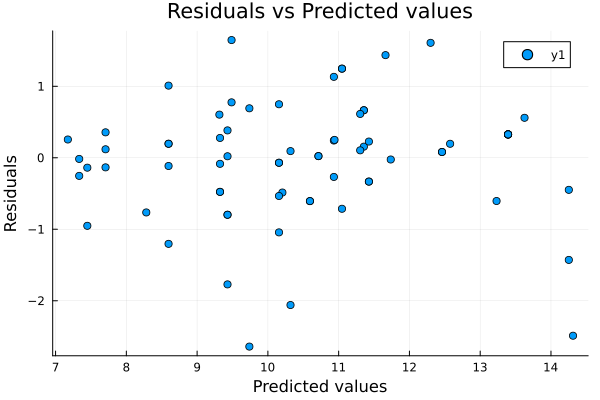

In [92]:
ŷ_train = GLM.predict(model, train)
ŷ_valid = GLM.predict(model, valid)

# Compute the RMSE
rmse_train = sqrt(mean((ŷ_train .- train.consommation).^2))
rmse_valid = sqrt(mean((ŷ_valid .- valid.consommation).^2))

valid.predicted = ŷ_valid

#plot dirstribtuion of residuals
residuals = ŷ_valid .- valid.consommation

println("RMSE on the training set: $rmse_train")
println("RMSE on the validation set: $rmse_valid")
#plot the residuals vs the predicted values
s = scatter(ŷ_valid, residuals, title="Residuals vs Predicted values", xlabel="Predicted values", ylabel="Residuals")

Pour la suite de l'étude de respect des hypothèses de l'application de la régression linéaire, nous devons vérifier que les résidus sont normalement distribués. Pour ce faire, nous avons tracé un histogramme des résidus et un graphique quantile-quantile. L'histogramme montre une ditribtuon relativement symétrique centrée autour de zéro. La forme de cloche attendue d'une distribution normale n'est pas tout à fait parfaite, mais elle est assez proche pour que nous puissions conclure que les résidus sont normalement distribués. Le graphique quantile-quantile confirme cette conclusion, avec une droite de régression qui passe par le centre des points. Par contre, il y aurait place à amélioration comme les points ne suivent pas parfaitement la droite. De plus, les déviations observées pour les valeurs extrêmes pourraient être dues à des valeurs abbérantes dans les données et leur impact serait à analyser dans le futur.

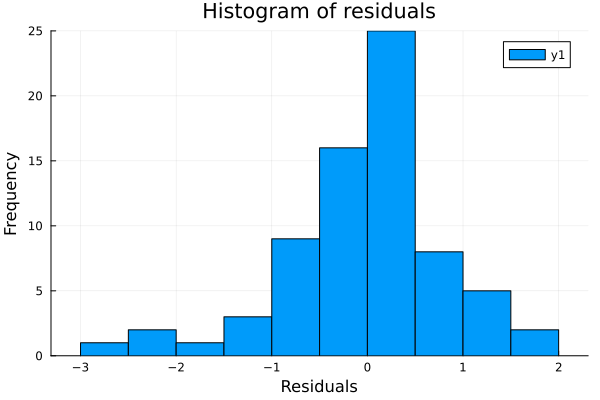

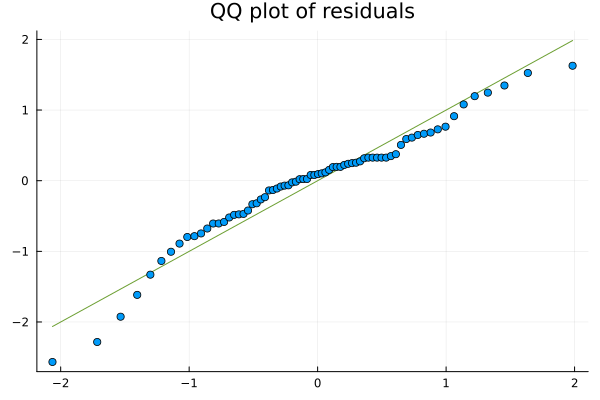

In [93]:
qq = qqnorm(residuals, title="QQ plot of residuals")

h = histogram(residuals, title="Histogram of residuals", xlabel="Residuals", ylabel="Frequency")

display(h)
display(qq)

Avant d'explorer d'autres techniques de régression, nous avons décidé de tester différents modèles pour voir si la sélection sur la base du coefficient de détermination $R^2_{ajusté}$  et du RMSE était cohérente. Pour ce faire, nous avons commencé par créer une matrice de structure ainsi qu'une matrice de réponse pour les données d'entraînement et de validation. 

In [94]:
# Define the feature matrix and target vector
X_train = Matrix(train[:, Not([:consommation])])
y_train = Vector(train.consommation)
X_valid = Matrix(valid[:, Not([:consommation])])
y_valid = Vector(valid.consommation)
X_test = Matrix(test)

150×22 Matrix{Float64}:
 2014.0  1.38629  0.916291  1.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 2014.0  1.38629  0.916291  1.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 2014.0  1.38629  0.916291  1.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 2014.0  1.38629  0.693147  1.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 2014.0  2.07944  1.75786   0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 2014.0  2.07944  1.60944   0.0  1.0  …  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 2014.0  2.07944  1.60944   0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 2014.0  1.38629  0.875469  1.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 2014.0  1.79176  1.25276   1.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 2014.0  2.30259  1.64866   0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  1.0
    ⋮                                 ⋱  ⋮                        ⋮    
 2024.0  1.38629  0.693147  1.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 2024.0  1.38629  0.693147  1.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 202

Dans cette cellule, nous énumérons les différentes formules allant de très simple à très complexe en terme de nombre de variable explicative et de relation pour prédire la consommation. Ceci est le résultat de différentes analyses et tests que nous avons effectués pour déterminer la meilleure formule pour prédire la consommation d'essence. Bien que cette liste ne soit pas exhaustive, elle nous permet de comparer les performances des différents modèles et de choisir celui qui est le plus performant.

In [97]:
models_formulas = [
    @formula(consommation ~ nombre_cylindres),
    @formula(consommation ~ cylindree),
    @formula(consommation ~ cylindree + nombre_cylindres),
    @formula(consommation ~ cylindree + boite_automatique),
    @formula(consommation ~ cylindree + boite_manuelle),
    @formula(consommation ~ cylindree + transmission_integrale),
    @formula(consommation ~ transmission_integrale + transmission_traction),
    @formula(consommation ~ transmission_integrale + nombre_cylindres),
    @formula(consommation ~ transmission_integrale + transmission_traction + cylindree),
    @formula(consommation ~ transmission_integrale + cylindree),
    @formula(consommation ~ transmission_integrale + cylindree),
    @formula(consommation ~ transmission_integrale + cylindree + nombre_cylindres),
    @formula(consommation ~ transmission_traction + cylindree + nombre_cylindres),
    @formula(consommation ~ transmission_integrale + cylindree + nombre_cylindres + boite_automatique),
    @formula(consommation ~ transmission_traction + cylindree + nombre_cylindres + boite_manuelle),
    @formula(consommation ~ transmission_integrale + transmission_traction + cylindree + nombre_cylindres + boite_automatique),
    @formula(consommation ~ transmission_traction + transmission_integrale + cylindree + nombre_cylindres + boite_manuelle),
    @formula(consommation ~ transmission_traction + categorie_vehicule_petits_véhicules + categorie_vehicule_véhicules_moyens + cylindree),
    @formula(consommation ~ transmission_integrale + categorie_vehicule_petits_véhicules + categorie_vehicule_grands_véhicules + categorie_vehicule_véhicules_moyens + boite_automatique + cylindree),
    @formula(consommation ~ transmission_integrale + categorie_vehicule_petits_véhicules + categorie_vehicule_grands_véhicules + categorie_vehicule_véhicules_moyens + boite_manuelle + cylindree),
    @formula(consommation ~ transmission_integrale + transmission_traction + categorie_vehicule_petits_véhicules + categorie_vehicule_grands_véhicules + categorie_vehicule_véhicules_moyens + cylindree),
    @formula(consommation ~ transmission_integrale + transmission_traction + categorie_vehicule_petits_véhicules + categorie_vehicule_grands_véhicules + categorie_vehicule_véhicules_moyens + cylindree + boite_automatique + boite_manuelle),
    @formula(consommation ~ transmission_integrale + transmission_traction + categorie_vehicule_petits_véhicules + categorie_vehicule_grands_véhicules + categorie_vehicule_véhicules_moyens + cylindree + boite_automatique),
    @formula(consommation ~ transmission_integrale + transmission_traction + categorie_vehicule_petits_véhicules + categorie_vehicule_grands_véhicules + categorie_vehicule_véhicules_moyens + cylindree + boite_manuelle),
    @formula(consommation ~ categorie_vehicule_petits_véhicules + categorie_vehicule_véhicules_moyens + categorie_vehicule_grands_véhicules + transmission_traction + cylindree + boite_automatique),   
    @formula(consommation ~ categorie_vehicule_petits_véhicules + categorie_vehicule_véhicules_moyens + categorie_vehicule_grands_véhicules + transmission_traction + cylindree + boite_manuelle + boite_automatique),
    @formula(consommation ~ categorie_vehicule_petits_véhicules + categorie_vehicule_véhicules_moyens + categorie_vehicule_grands_véhicules + transmission_traction + cylindree + boite_manuelle ),
    @formula(consommation ~ transmission_traction + categorie_vehicule_petits_véhicules + categorie_vehicule_véhicules_moyens + cylindree),
    @formula(consommation ~ transmission_traction  + cylindree + boite_automatique),
    @formula(consommation ~ transmission_traction  + cylindree + boite_manuelle),
    @formula(consommation ~ transmission_integrale + cylindree + boite_manuelle),
    @formula(consommation ~ transmission_traction + cylindree + boite_automatique),
    @formula(consommation ~ transmission_traction + cylindree + type_voiture_moyenne + type_VUS_petit + type_voiture_compacte + type_voiture_deux_places + type_voiture_minicompacte + type_VUS_standard + type_voiture_sous_compacte + type_break_petit + type_voiture_grande + type_camionnette_standard + transmission_integrale + boite_manuelle),
    @formula(consommation ~ transmission_traction + cylindree + type_voiture_moyenne + type_VUS_petit + type_voiture_compacte + type_voiture_deux_places + type_voiture_minicompacte + type_VUS_standard + type_voiture_sous_compacte + type_break_petit + type_voiture_grande + type_camionnette_standard + transmission_integrale + boite_automatique),
    @formula(consommation ~ cylindree +  type_voiture_moyenne + type_VUS_petit + type_voiture_compacte + type_voiture_deux_places + type_voiture_minicompacte + type_VUS_standard + type_voiture_sous_compacte + type_break_petit + type_voiture_grande + type_camionnette_standard + transmission_integrale + transmission_traction + boite_manuelle),
    @formula(consommation ~ cylindree +  type_voiture_moyenne + type_VUS_petit + type_voiture_compacte + type_voiture_deux_places + type_voiture_minicompacte + type_VUS_standard + type_voiture_sous_compacte + type_break_petit + type_voiture_grande + type_camionnette_standard + transmission_integrale + transmission_traction + boite_automatique),
    @formula(consommation ~ transmission_integrale + transmission_traction + cylindree + type_voiture_moyenne + type_VUS_petit + type_voiture_compacte + type_voiture_deux_places + type_voiture_minicompacte + type_VUS_standard + type_voiture_sous_compacte + type_break_petit + type_voiture_grande + type_camionnette_standard),
    @formula(consommation ~ cylindree + type_voiture_moyenne + type_VUS_petit + type_voiture_compacte + type_voiture_deux_places + type_voiture_minicompacte + type_VUS_standard + type_voiture_sous_compacte + type_break_petit + type_voiture_grande + type_camionnette_standard)
    ]

38-element Vector{FormulaTerm{Term}}:
 consommation ~ nombre_cylindres
 consommation ~ cylindree
 consommation ~ cylindree + nombre_cylindres
 consommation ~ cylindree + boite_automatique
 consommation ~ cylindree + boite_manuelle
 consommation ~ cylindree + transmission_integrale
 consommation ~ transmission_integrale + transmission_traction
 consommation ~ transmission_integrale + nombre_cylindres
 consommation ~ transmission_integrale + transmission_traction + cylindree
 consommation ~ transmission_integrale + cylindree
 ⋮
 consommation ~ transmission_traction + cylindree + boite_manuelle
 consommation ~ transmission_integrale + cylindree + boite_manuelle
 consommation ~ transmission_traction + cylindree + boite_automatique
 consommation ~ transmission_traction + cylindree + type_voiture_moyenne + type_VUS_petit + type_voiture_compacte + type_voiture_deux_places + type_voiture_minicompacte + type_VUS_standard + type_voiture_sous_compacte + type_break_petit + type_voiture_grande + ty

C'est alors ici, que nous comparons les modèles avec les critères $R^2_{ajusté}$, RMSE et BIC. L'idée était d'étudier si les différents critères étaient cohérents entre eux et de choisir le modèle qui performait le mieux selon ces critères. Dans ce cas, nous voulions maximiser le $R^2_{ajusté}$ et le BIC et minimiser le RMSE. Selon nos le $R^2_{ajusté}$ et le RMSE, le modèle regroupant transmission_integrale, transmission_traction, categorie_vehicule_petits_véhicules, categorie_vehicule_grands_véhicules, categorie_vehicule_véhicules_moyens et cylindree performe le mieux. Par contre, selon le BIC le modèle regroupant transmission_integrale, cylindree, nombre_cylindres et boite_automatique est le plus performant, mais le RMSE associé est plus élevé. Évidemment, avec le BIC, on pénalise sévèrement les modèles avec trop de paramètres pour éviter le sur-ajustement, et on privilégie les variables explicatives les plus importantes. En revanche, le critère de rmse ne pénalise pas la quantité de variables explicatives, et le $R^2_{ajusté}$ serait un compromis. Le fait que le choix de modèle selon le $R^2_{ajusté}$ soit le même que selon le RMSE nous pousse à choisir le modèle regroupant transmission_integrale, transmission_traction, categorie_vehicule_petits_véhicules, categorie_vehicule_grands_véhicules, categorie_vehicule_véhicules_moyens et cylindree.

In [98]:
best_rajs= -Inf
best_rmse = Inf
best_bic = -Inf
bic_rmse = Inf
best_model_by_raj = nothing
best_model_by_rmse = nothing
best_model_by_bic = nothing

for formula in models_formulas
    model = lm(formula, train)
    ŷ = GLM.predict(model, valid)
    local raj_valid = compute_raj(X_valid, y_valid, ŷ)
    local bic_valid = compute_bic(X_valid, model)
    local rmse_valid = sqrt(mean((ŷ .- y_valid).^2))

    global best_rmse, best_rajs, best_model_by_rmse, best_model_by_raj, best_bic, best_model_by_bic, bic_rmse
    if rmse_valid < best_rmse
        best_rmse = rmse_valid
        best_model_by_rmse = formula
    end

    if bic_valid > best_bic
        best_bic = bic_valid
        best_model_by_bic = formula
        bic_rmse = rmse_valid
    end

    if raj_valid > best_rajs
        best_rajs = raj_valid
        best_model_by_raj = formula
    end
end

println("\n-------------------------------------")
println("Best model by Raj: ", best_model_by_raj)
println("Best Raj: ", best_rajs)

println("Best model by RMSE: ", best_model_by_rmse)
println("Best RMSE: ", best_rmse)

println("Best model by BIC: ", best_model_by_bic)
println("Best BIC: ", best_bic)
println("RMSE for the best BIC: ", bic_rmse)
println("-------------------------------------")


-------------------------------------
Best model by Raj: consommation ~ transmission_integrale + transmission_traction + categorie_vehicule_petits_véhicules + categorie_vehicule_grands_véhicules + categorie_vehicule_véhicules_moyens + cylindree
Best Raj: 0.746320430590865
Best model by RMSE: consommation ~ transmission_integrale + transmission_traction + categorie_vehicule_petits_véhicules + categorie_vehicule_grands_véhicules + categorie_vehicule_véhicules_moyens + cylindree
Best RMSE: 0.8287139392584507
Best model by BIC: consommation ~ transmission_integrale + cylindree + nombre_cylindres + boite_automatique
Best BIC: -399.4918848658553
RMSE for the best BIC: 0.9509088378121013
-------------------------------------


In [ ]:
ŷ_test = GLM.predict(lm(best_model_by_rmse, train), test)

n_test = size(ŷ_test, 1)
id = 1:n_test
df_pred = DataFrame(id=id, consommation=ŷ_test)

name = string(best_rmse) * ".csv"
CSV.write("../submissions/linear/" * name, df_pred)
println("Predictions exported successfully to " * name * ".")

## 5. Régression bayesienne

In [ ]:
# Datasets that contain 'consommation'
datasets_with_consommation = [train, valid]

# Datasets without 'consommation'
datasets_without_consommation = [test]

# Apply replacements to 'cylindree' in all datasets
for df in [train, valid, test]
    df.cylindree = replace.(df.cylindree, "," => ".")
end

# Apply replacements to 'consommation' only in datasets that have it
for df in datasets_with_consommation
    df.consommation = replace.(df.consommation, "," => ".")
end

# Convert 'cylindree' to float in all datasets
for df in [train, valid, test]
    df.cylindree = safe_parse_float.(df.cylindree)
end

# Convert 'consommation' to float in datasets with 'consommation'
for df in datasets_with_consommation
    df.consommation = safe_parse_float.(df.consommation)
end

# Drop missing values in all datasets
for df in [train, valid, test]
    dropmissing!(df)
end

# # Encode 'boite' column in all datasets
# for df in [train, valid, test]
#     df.boite = ifelse.(df.boite .== "automatique", 1.0, 0.0)
# end


In [ ]:
# Define categorical columns
categorical_cols = [:type, :transmission, :boite]

# Collect unique levels from the training set
levels_dict = Dict()
for col in categorical_cols
    levels_dict[col] = unique(train[!, col])
end

train = one_hot_encode(train, categorical_cols, levels_dict)
valid = one_hot_encode(valid, categorical_cols, levels_dict)
test = one_hot_encode(test, categorical_cols, levels_dict)

In [ ]:
y_train = train.consommation
X_train = select(train, Not(:consommation))
y_valid = valid.consommation
X_valid = select(valid, Not(:consommation))
X_test = deepcopy(test)


In [ ]:
# Identify numeric feature indices
feature_names = names(train)
numeric_features = [ :cylindree, :nombre_cylindres, :age]
numeric_indices = findall(x -> x in numeric_features, feature_names)

means = mean(Matrix(X_train[:, numeric_features]), dims=1)
stds = std(Matrix(X_train[:, numeric_features]), dims=1)

In [ ]:
function standardizer(X, means, stds)
    X = deepcopy(X)
    for j in 1:size(X, 2)
        if j in numeric_indices
            X[:, j] = (X[:, j] .- means[j]) ./ stds[j]
        end
    end
    return X
end

In [ ]:
X_train = standardizer(Matrix(X_train), means, stds)
X_valid = standardizer(Matrix(X_valid), means, stds)
X_test = standardizer(Matrix(X_test), means, stds)

y_train = Vector(y_train)
y_valid = Vector(y_valid)

In [ ]:
# Ridge regression with cross-validation
XtX = X_train' * X_train
Xty = X_train' * y_train
n_features = size(X_train, 2)

In [ ]:
describe(valid)

In [ ]:
lambda_values = 10 .^ range(-5, stop=5, length=1000)
best_rmse = Inf
best_lambda = 0.0
best_beta = nothing


for λ in lambda_values
    beta = (XtX + λ * I) \ Xty
    y_pred_valid = X_valid * beta
    rmse = sqrt(mean((y_pred_valid - y_valid).^2))
    if rmse < best_rmse
        best_rmse = rmse
        best_lambda = λ
        best_beta = beta
    end
end

println("Best Lambda: ", best_lambda)
println("Best RMSE: ", best_rmse)

In [ ]:
# # Evaluation on validation set
y_valid_pred = X_valid * best_beta
rmse_valid = sqrt(mean((y_valid_pred - y_valid).^2))
println("Validation RMSE: ", rmse_valid)

# Predictions on test set
y_test_pred = X_test * best_beta

# Prepare submission DataFrame
n_test = size(y_test_pred, 1)
id = 1:n_test
df_pred = DataFrame(id=id, consommation=y_test_pred)

name = "ridge" * string(rmse_valid) * ".csv"
CSV.write("../submissions/bayes/" * name, df_pred)
println("Predictions exported successfully to " * name*".")

## 6. Validation par k-fold cross-validation

In [ ]:
data_k_folds = vcat(train, valid)
y = data_k_folds.consommation
X = select(data_k_folds, Not(:consommation))

n = nrow(data_k_folds)
k = 5  
fold_size = n ÷ k

indices = randperm(n)

rms_scores = []

for i in 0:(k-1)
    test_indices = indices[(i*fold_size + 1):min((i+1)*fold_size, n)]
    train_indices = setdiff(indices, test_indices)
    
    train_data = data_k_folds[train_indices, :]
    test_data = data_k_folds[test_indices, :]
    
    model = lm(@formula(consommation ~ age  + transmission_integrale + transmission_propulsion + transmission_traction + transmission_4x4 + cylindree), data_k_folds)
 
    
    valid_prediction = GLM.predict(model, test_data)
    
    mean_prediction = mean(skipmissing(valid_prediction))
    valid_prediction = coalesce.(valid_prediction, mean_prediction)
    
    if any(ismissing, valid_prediction)
        error("Skip les valeur missing")
    end
    
    v = max.(valid_prediction, 0) 
    
    score = sqrt(mean((v - test_data.consommation).^2))
    push!(rms_scores, score)
end

moyenne_rmse = mean(rms_scores)
println("Moyenne RMSE : $moyenne_rmse")

# Ajouter à la section type de véhicules pour justifier que les catégories sont relevant

In [ ]:
using Pkg
Pkg.add("HypothesisTests")

using StatsModels, GLM, HypothesisTests

# Ajuster le modèle complet
model_full = lm(@formula(consommation ~ categorie_vehicule), train)

# Ajuster le modèle réduit
model_reduced = lm(@formula(consommation ~ 1), train)

# Effectuer le test F
ftest_result = ftest(model_full.model, model_reduced.model)
println(ftest_result)

## 7. Régression par l'approche des composantes principales

###### TODO CONCLUSION

In [ ]:
using CSV, DataFrames, Statistics, Dates, Gadfly, Combinatorics, Plots, StatsBase, StatsPlots, Random, StatsModels, GLM, LinearAlgebra, MultivariateStats, Distributions

full_train = CSV.read("../data/raw/train.csv", DataFrame; delim=";")
test =  CSV.read("../data/raw/test.csv", DataFrame; delim=";")

Random.seed!(1234)

ntrain = round(Int, .8*nrow(full_train)) #80% des données pour l'entrainement: 80% * nb de lignes

train_id = sample(1:nrow(full_train), ntrain, replace=false, ordered=true) #échantillonnage aléatoire pour l'entrainement
valid_id = setdiff(1:nrow(full_train), train_id) #échantillon de validation. prend celles qui ne sont pas dans l'échantillon d'entrainement

train = full_train[train_id, :]  
valid = full_train[valid_id, :]

train = dropmissing(train)
valid = dropmissing(valid)
test = dropmissing(test)

In [ ]:
datasets_with_consommation = [train, valid]

datasets_without_consommation = [test]

for df in [train, valid, test]
    df.cylindree = replace.(df.cylindree, "," => ".")
end

for df in datasets_with_consommation
    df.consommation = replace.(df.consommation, "," => ".")
end

for df in [train, valid, test]
    df.cylindree = safe_parse_float.(df.cylindree)
end

for df in datasets_with_consommation
    df.consommation = safe_parse_float.(df.consommation)
end

for df in [train, valid, test]
    df.boite = ifelse.(df.boite .== "automatique", 1.0, 0.0)
end

In [ ]:
train = remove_outliers_by_iqr(train, :cylindree, :consommation)
valid = remove_outliers_by_iqr(valid, :cylindree, :consommation)

In [ ]:
categorical_cols = [:type, :transmission]

levels_dict = Dict()
for col in categorical_cols
    levels_dict[col] = unique(train[!, col])
end


train = one_hot_encode(train, categorical_cols, levels_dict)
valid = one_hot_encode(valid, categorical_cols, levels_dict)
test = one_hot_encode(test, categorical_cols, levels_dict)

In [ ]:
y_train = train.consommation
X_train = select(train, Not(:consommation))
y_valid = valid.consommation
X_valid = select(valid, Not(:consommation))
X_test = deepcopy(test)

X_train = Matrix(select(train, Not(:consommation)))
X_valid = Matrix(select(valid, Not(:consommation)))
X_test = Matrix(test)

y_train = Vector(y_train)
y_valid = Vector(y_valid)

# Standardize the data (commented out)
# X_mean = mean(X_train; dims=1)
# X_stddev = std(X_train; dims=1, corrected=false)
# X_train_std = (X_train .- X_mean) ./ X_stddev
# X_valid_std = (X_valid .- X_mean) ./ X_stddev

In [ ]:
pca_model = fit(PCA, X_train'; maxoutdim=5)
Z_train = MultivariateStats.transform(pca_model, X_train')'
Z_valid = MultivariateStats.transform(pca_model, X_valid')'
Z_test = MultivariateStats.transform(pca_model, X_test')'

# Add principal components to DataFrames (train and valid)
for i in 1:size(Z_train, 2)
    train[:, "PC$(i)"] = Z_train[:, i]
    valid[:, "PC$(i)"] = Z_valid[:, i]
    test[:, "PC$(i)"] = Z_test[:, i]
end

# Fit a regression model using PCA
model_with_pca = lm(@formula(consommation ~ PC1 + PC2 + PC3 + PC4 + PC5), train)

# Predict on validation data
valid_prediction_with_pca = predict(model_with_pca, valid)

# Calculate RMSE
rmse_with_pca = sqrt(mean((valid_prediction_with_pca - valid.consommation).^2))
println("RMSE with PCA: ", rmse_with_pca)

In [ ]:
#k fold cross validation
data_k_folds = vcat(train, valid)
y = data_k_folds.consommation
X = select(data_k_folds, Not(:consommation))

n = nrow(data_k_folds)
k = 5
fold_size = n ÷ k

indices = randperm(n)

rms_scores = []

for i in 0:(k-1)
    valid_indices = (i * fold_size + 1):((i + 1) * fold_size)
    train_indices = setdiff(1:n, valid_indices)
    
    X_train = X[train_indices, :]
    y_train = y[train_indices]
    X_valid = X[valid_indices, :]
    y_valid = y[valid_indices]
    
    model = lm(@formula(consommation ~ PC1 + PC2 + PC3 + PC4 + PC5), train)
    
    ŷ_valid = GLM.predict(model, X_valid)
    rms = sqrt(mean((ŷ_valid .- y_valid).^2))
    push!(rms_scores, rms)
end

moyenne_rmse = mean(rms_scores)
println("Moyenne RMSE k-fold : $moyenne_rmse")

In [ ]:
1. Impact des échelles dans les données
Dans les données non standardisées, les variables explicatives ayant des valeurs plus grandes peuvent dominer la variance totale, ce qui oriente la PCA vers ces variables. Si ces variables sont fortement corrélées avec la variable cible (
𝑌
Y), alors le modèle peut accidentellement mieux capturer cette relation.
En revanche, la standardisation neutralise les différences d'échelle, ce qui peut diluer l'effet des variables dominantes, même si elles ont une forte corrélation avec 
𝑌
Y.
Explication potentielle :
Dans votre jeu de données, il est possible qu'une ou plusieurs variables avec des échelles plus grandes soient prédictives de 
𝑌
Y, et la méthode non standardisée en profite directement.

In [ ]:
2. Sur-ajustement (Overfitting)
La méthode non standardisée applique la PCA sur les données d'origine, mais utilise ensuite les données reconstruites (
𝑋
𝑟
X 
r
​
 ) pour l'entraînement. Cela peut réintroduire une grande partie des informations originales, y compris le bruit ou les corrélations spurielles, ce qui peut conduire à un modèle sur-ajusté.
Si l'ensemble de validation est similaire à l'ensemble d'entraînement (par exemple, s'il provient de la même distribution ou a des caractéristiques similaires), un sur-ajustement peut donner des RMSE artificiellement bas.
Explication potentielle :
Votre validation pourrait être moins rigoureuse, et la méthode non standardisée exploite des relations non généralisables dans les données.



In [ ]:

Le fait que la méthode non standardisée donne un meilleur RMSE peut s'expliquer par plusieurs raisons, mais cela ne signifie pas nécessairement qu'elle est meilleure ou qu'elle respecte les principes statistiques sous-jacents. Explorons pourquoi cela pourrait se produire :

1. Impact des échelles dans les données
Dans les données non standardisées, les variables explicatives ayant des valeurs plus grandes peuvent dominer la variance totale, ce qui oriente la PCA vers ces variables. Si ces variables sont fortement corrélées avec la variable cible (
𝑌
Y), alors le modèle peut accidentellement mieux capturer cette relation.
En revanche, la standardisation neutralise les différences d'échelle, ce qui peut diluer l'effet des variables dominantes, même si elles ont une forte corrélation avec 
𝑌
Y.
Explication potentielle :
Dans votre jeu de données, il est possible qu'une ou plusieurs variables avec des échelles plus grandes soient prédictives de 
𝑌
Y, et la méthode non standardisée en profite directement.

2. Sur-ajustement (Overfitting)
La méthode non standardisée applique la PCA sur les données d'origine, mais utilise ensuite les données reconstruites (
𝑋
𝑟
X 
r
​
 ) pour l'entraînement. Cela peut réintroduire une grande partie des informations originales, y compris le bruit ou les corrélations spurielles, ce qui peut conduire à un modèle sur-ajusté.
Si l'ensemble de validation est similaire à l'ensemble d'entraînement (par exemple, s'il provient de la même distribution ou a des caractéristiques similaires), un sur-ajustement peut donner des RMSE artificiellement bas.
Explication potentielle :
Votre validation pourrait être moins rigoureuse, et la méthode non standardisée exploite des relations non généralisables dans les données.

3. Corrélation forte entre les variables
Si les variables explicatives ont une forte corrélation intrinsèque, l'analyse en composantes principales standardisée peut répartir cette information sur plusieurs composantes. Cela réduit la capacité du modèle à se concentrer sur des variables fortement corrélées avec 
𝑌
Y.
La méthode non standardisée, en revanche, conserve ces corrélations et peut donc mieux modéliser la relation entre 
𝑋
X et 
𝑌
Y.
Explication potentielle :
Les corrélations fortes dans vos données favorisent la méthode non standardisée.

In [ ]:
4. Effet des données reconstruites
Dans la méthode non standardisée, vous utilisez des données reconstruites (
𝑋
𝑟
X 
r
​
 ), qui incluent une grande partie de l'information originale. Cela signifie que la régression est moins influencée par la réduction de dimension et plus proche de la régression sur les données d'origine.
En revanche, dans la méthode standardisée, seules les composantes principales sont utilisées, ce qui peut sacrifier une partie de l'information pour réduire la multicolinéarité et améliorer la généralisation.
Explication potentielle :
L'utilisation des données reconstruites dans la méthode non standardisée maintient plus d'information, ce qui peut donner un RMSE plus faible.



In [ ]:
5. Problème avec la PCA standardisée
Si la standardisation n'est pas appropriée (par exemple, si certaines variables explicatives sont presque constantes ou si elles sont déjà sur des échelles comparables), alors l'analyse en composantes principales standardisée peut ne pas capturer efficacement les directions principales de la variance.
Cela peut entraîner une perte d'information utile, ce qui affecte les performances du modèle.
Explication potentielle :
Les variables de votre jeu de données n'ont peut-être pas besoin d'être standardisées ou la standardisation introduit un biais.

## 8. Conclusion

En conclusion, nous avons montré dans ce rapport l'entièreté de notre processus de développement d'un modèle prédictif permettant d'estimer la consommation d'essence d'un véhicule à partir de ses caractéristiques, notamment son année de fabrication, son type, son nombre de cylindres, sa cylindrée, sa transmission et son type de boîte.

Pour ce faire, nous avons commencé par analyser le jeu de données qui nous était fourni afin de trouver autant de pistes à explorer que possible pour préparer nos données d'entraînement de façon à optimiser les performances de notre modèle.  Nous avons traité les données catégorielles (non numériques) en utilisant du one-hot encoding, analysé les relations entre les variables explicatives, linéarisé des données suivant une courbe normale, regroupé des données par catégories, retirer des données manquantes ou trop éloignées de la moyenne (outliers) et plus encore, le tout dans le but de soutirer un maximum d'informations ayant le potentiel de rendre notre modèle meilleur.

Par la suite, nous avons tout mis en oeuvre pour entraîner le modèle le mieux adapté à notre situation précise.  Nous avons testé trois méthodes principales vues dans le cours, soit la régression linéaire, la régression bayésienne, et l'analyse par composantes principales.  Nous avons testé avec toutes sortes de combinaisons de variables explicatives injectées dans ces modèles, avec différentes solutions de pré-traitement, et ces choix étaient directement informés par l'analyse mentionnée précédemment.  Nous avons également utilisé des métriques variées, notamment le RMSE, le BIC et le ${R_{aj}^2}$, afin d'évaluer les meilleurs modèles pour effectuer nos prédictions.

Au final, nous avons choisi comme modèle final pour notre ultime soumission un modèle basé sur la régression linéaire qui inclut comme variables explicatives la transmission de type intégrale, la transmission de type traction, la catégorie des petits véhicules, la catégorie des grands véhicules, la catégorie des véhicules moyens, et la cylindrée.  Ce modèle nous donne un RMSE de 0.8287 dans nos tests, ce qui est notre meilleur résultat : c'est la raison pour laquelle nous avons privilégié ce modèle plutôt que la régression bayésienne ou l'analyse par composantes principales, qui donnent des RMSE plus élevés pour la même sélection de variables explicatives.

Malgré nos meilleurs efforts, le fruit de notre travail s'est traduit par un piètre score de RMSE de 0.9298 dans la compétition Kaggle et une 16e place.  C'est un résultat décevant, particulièrement pour des étudiants motivés et compétitifs comme nous sommes.  Malgré tout, nous avons eu relativement peu de temps à consacrer à ce projet en raison de la fin laborieuse de notre projet intégrateur de 3e année, et nous sommes satisfaits d'avoir pu apprendre autant sur un sujet aussi intéressant dans un laps de temps assez court.

Afin d'améliorer ce score, d'autres pistes que nous aurions pu explorer sont d'enrichir le prétraitement des données en analysant les interactions entre les variables explicatives de façon plus approfondie et d'utiliser des techniques plus poussées de normalisation et de standardisation des données, d'augmenter la quantité de données à notre disposition à l'aide d'un nouveau jeu de données ou d'un ensemble de données généré artificiellement par une technique d'augmentation, ou encore d'utiliser un modèle prédictif plus avancé comme un XGBoost ou une forêt aléatoire.  Les possibilités sont infinies.